In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import linalg as LA
import scipy.misc
import scipy.optimize

# Parameters



In [2]:
step_size=1. # starting step_size for gradient descent
no_of_pts = 500 # size of dataset
dim_in=2 # the input dimension
dim_layer_1=4 # the size of the first hidden layer in the network
dim_layer_2=6
dim_layer_3=4
args = [no_of_pts,dim_in,dim_layer_1,dim_layer_2,dim_layer_3]

# Network

In [3]:
# Sigmoid activation function 
# its derivative is given by f'(x)=f(x)(1-f(x))
def activation(x,deriv=False):
    if(deriv==True):
        return x*(1-x)
    return 1./(1+np.exp(-x))

In [4]:
# Construct network, which has two hidden layers of size indim=2-3-4-1, therefore we will have 6+12+4=22 weights
def network_function(inputs,u,v,w,x):
    layer_1 =  activation(np.dot(inputs,u)) # (batch_size, dim_layer_1)
    layer_2 = activation(np.dot(layer_1,v)) # (batch_size, dim_layer_2)
    layer_3 = activation(np.dot(layer_2,w)) # (dim_layer_2, dim_layer_3)
    guess = np.dot(layer_3,x) # (batch_size, dim_out)
    return guess


# Flattening and unflattening for optimization function

In [5]:
def flat_weights(U,V,W,X):
    return np.concatenate([U.flatten(),V.flatten(),W.flatten(),X.flatten()])

def unflat_weights(weights_flat, args):
    U = weights_flat[:args[1]*args[2]].reshape(args[1],args[2])
    V = weights_flat[args[1]*args[2]: (args[1]+args[3])*args[2]].reshape(args[2],args[3])
    W = weights_flat[(args[1]+args[3])*args[2]:(args[1]+args[3])*args[2]+args[3]*args[4]].reshape(args[3],args[4])
    X = weights_flat[(args[1]+args[3])*args[2]+args[3]*args[4]:].reshape(args[4],1)
    return U,V,W,X

def flat_dataset_and_args(inputs, labels, args):
    return np.concatenate([inputs.flatten(), labels.flatten(),args])

def unflat_dataset_and_args(dataset_and_args_flat):
    args = dataset_and_args_flat[-5:].astype(int)
    inputs = dataset_and_args_flat[:args[0]*args[1]].reshape(args[0],args[1])
    labels = dataset_and_args_flat[args[0]*args[1]:-5].reshape(args[0],1)
    return inputs, labels, args

def optimizer_function(weights_flat,dataset_and_args_flat):
    inputs,labels,args = unflat_dataset_and_args(dataset_and_args_flat)
    U,V,W,X = unflat_weights(weights_flat,args)
    guess = network_function(inputs,U,V,W,X)
    error = np.sum((guess-labels)**2)
    return error

# Main loop checking matrices B and D

In [6]:
no_of_seeds = 1000

# 0 = pos def
# 1 = neg def
# -1 = neither
D_max_entries_layer_1 = np.zeros((no_of_seeds,dim_layer_1))
B_coding_layer_1 = np.zeros((no_of_seeds,dim_layer_1))

D_max_entries_layer_2 = np.zeros((no_of_seeds,dim_layer_2))
B_coding_layer_2 = np.zeros((no_of_seeds,dim_layer_2))

D_max_entries_layer_3 = np.zeros((no_of_seeds,dim_layer_3))
B_coding_layer_3 = np.zeros((no_of_seeds,dim_layer_3))

test=0

errors = np.zeros(no_of_seeds)

for i in range(no_of_seeds):
    np.random.seed(i)
    print("Random seed:"+str(i))
    # Initialze weights for layers randomly
    u = 10*np.random.random((dim_in,2*dim_layer_1))-5 # (dim_in, dim_layer_1)
    v = 10*np.random.random((2*dim_layer_1,2*dim_layer_2))-5  # (dim_layer_1, dim_layer_2)
    w = 10*np.random.random((2*dim_layer_2,2*dim_layer_3))-5  # (dim_layer_2, dim_layer_3)
    x = 10*np.random.random((2*dim_layer_3,1))-5  # (dim_layer_3, dim_out)
    
    inputs =np.random.random((no_of_pts,dim_in))
    # Create labels
    labels = network_function(inputs,u,v,w,x)
    
    # Create smaller network by initializing new weights
    U = 10*np.random.random((dim_in,dim_layer_1))-5 # (dim_in, dim_layer_1)
    V = 10*np.random.random((dim_layer_1,dim_layer_2))-5  # (dim_layer_1, dim_layer_2)
    W = 10*np.random.random((dim_layer_2,dim_layer_3))-5  # (dim_layer_2, dim_layer_3)
    X = 10*np.random.random((dim_layer_3,1))-5  # (dim_layer_3,1)

    weights_flat = flat_weights(U,V,W,X)
    dataset_and_args_flat = flat_dataset_and_args(inputs, labels, args)
    
    result = scipy.optimize.minimize( optimizer_function , weights_flat, dataset_and_args_flat, method='BFGS')
    
    U,V,W,X = unflat_weights(result['x'],args)
    
    error =  optimizer_function(result['x'], dataset_and_args_flat)
    print("Error after training = "+str(error))
    errors[i]=error
    
    # Check positive definiteness of matrix to add a neuron to first hidden layer
    guess=network_function(inputs,U,V,W,X)
    layer_1 = activation(np.dot(inputs,U)) # (batch_size, dim_layer_1)
    layer_2 = activation(np.dot(layer_1,V)) #(batch_size, dim_layer_2)
    layer_3 = activation(np.dot(layer_2,W))
    
    print('First hidden layer:')
    for r in range(dim_layer_1):
        
        dh_by_dn =np.dot(np.dot(np.ones((no_of_pts,1)),X.T)*activation(layer_3, deriv=True),W.T)*activation(layer_2, deriv=True)
        sigma_double_prime = (layer_1[:,r] - 3*layer_1[:,r]**2+2*layer_1[:,r]**3)
        summands=((guess-labels)*np.dot(dh_by_dn,V[r,:]).reshape(no_of_pts,1) *sigma_double_prime.reshape(no_of_pts,1)).reshape(no_of_pts,1,1) *(inputs.reshape(no_of_pts,1,dim_in)*inputs.reshape(no_of_pts,dim_in,1))
        B=np.sum(summands,axis=0)

        eigenValues = np.linalg.eig(B)[0]
        definiteness = ""
        if all(j > 0 for j in eigenValues):
            definiteness="positive definite"
            B_coding_layer_1[i,r]=0
        elif all(j < 0 for j in eigenValues):
            definiteness="negative definite"
            B_coding_layer_1[i,r]=1
        else:
            definiteness= "Neither positive nor negative definite."
            B_coding_layer_1[i,r]=-1
        print("Neuron "+str(r)+": "+definiteness)
        
        D=np.sum(((guess-labels).reshape(no_of_pts,1)*dh_by_dn).reshape(no_of_pts,6,1)*(layer_1[:,r]*(1-layer_1[:,r])).reshape(no_of_pts,1,1)*inputs.reshape(no_of_pts,1,2),axis=0)
        D_max=D.max()
        D_max_entries_layer_1[i,r]=D_max
        print("\t and max entry of D is "+str(D_max) )
    print("---------------------------------------------------")
    
    print('Second hidden layer:')
    for r in range(dim_layer_2):
    
        dh_by_dn =np.dot(np.ones((no_of_pts,1)),X.T)*activation(layer_3, deriv=True) #Check here
        sigma_double_prime = (layer_2[:,r] - 3*layer_2[:,r]**2+2*layer_2[:,r]**3)
        summands=((guess-labels)*np.dot(dh_by_dn,W[r,:]).reshape(no_of_pts,1) *sigma_double_prime.reshape(no_of_pts,1)).reshape(no_of_pts,1,1) *(layer_1.reshape(no_of_pts,1,dim_layer_1)*layer_1.reshape(no_of_pts,dim_layer_1,1))
        B=np.sum(summands,axis=0)

        eigenValues = np.linalg.eig(B)[0]
        definiteness = ""
        if all(i > 0 for i in eigenValues):
            definiteness="positive definite"
            B_coding_layer_2[i,r]=0
        elif all(i < 0 for i in eigenValues):
            definiteness="negative definite"
            B_coding_layer_2[i,r]=1
        else:
            definiteness= "Neither positive nor negative definite."
            B_coding_layer_2[i,r]=-1
        print("Neuron "+str(r)+": "+definiteness)
        
        D=np.sum(((guess-labels).reshape(no_of_pts,1)*dh_by_dn).reshape(no_of_pts,4,1)*(layer_2[:,r]*(1-layer_2[:,r])).reshape(no_of_pts,1,1)*layer_1.reshape(no_of_pts,1,dim_layer_1),axis=0)
        D_max=D.max()
        D_max_entries_layer_2[i,r]=D_max
        print("\t and max entry of D is "+str(D_max) )
    print("---------------------------------------------------")
    
    print('Last hidden layer:')
    for r in range(dim_layer_3):
    
        dh_by_dn =np.ones((no_of_pts,1)) #Check here
        sigma_double_prime = (layer_3[:,r] - 3*layer_3[:,r]**2+2*layer_3[:,r]**3)
        summands=((guess-labels)*np.dot(dh_by_dn,X[r,:]).reshape(no_of_pts,1) *sigma_double_prime.reshape(no_of_pts,1)).reshape(no_of_pts,1,1) *(layer_2.reshape(no_of_pts,1,dim_layer_2)*layer_2.reshape(no_of_pts,dim_layer_2,1))
        B=np.sum(summands,axis=0)

        eigenValues = np.linalg.eig(B)[0]
        definiteness = ""
        if all(i > 0 for i in eigenValues):
            definiteness="positive definite"
            B_coding_layer_3[i,r]=0
        elif all(i < 0 for i in eigenValues):
            definiteness="negative definite"
            B_coding_layer_3[i,r]=1
        else:
            definiteness= "Neither positive nor negative definite."
            B_coding_layer_3[i,r]=-1
        print("Neuron "+str(r)+": "+definiteness)
        
        D=np.sum(((guess-labels).reshape(no_of_pts,1)*dh_by_dn).reshape(no_of_pts,1,1)*(layer_3[:,r]*(1-layer_3[:,r])).reshape(no_of_pts,1,1)*layer_2.reshape(no_of_pts,1,dim_layer_2),axis=0) 
        D_max=D.max()
        D_max_entries_layer_3[i,r]=D_max
        print("\t and max entry of D is "+str(D_max) )
    print("---------------------------------------------------")    
    print("---------------------------------------------------")
    
    

Random seed:0
Error after training = 0.0018543827208881395
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 9.216946249874444e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00040391486491719733
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 9.809118981393145e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0002857808916815496
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.882728230282388e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 9.163921815516203e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.5948083528104772e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 7.898390963973628e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.0


Error after training = 0.0012889743186798933
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0002286177147398375
Neuron 1: positive definite
	 and max entry of D is 0.00036112126632394136
Neuron 2: positive definite
	 and max entry of D is 0.0003579040529925912
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.000146079406651933
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.5471346776020663e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.2660343513646255e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.5948879442284587e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.5244632972352865e-11
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 6.280741364978101e-05
Neuron 5: Neither positive nor negativ

Error after training = 0.0003436388251311717
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 4.563044288738258e-05
Neuron 1: negative definite
	 and max entry of D is 1.7570921810340194e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.245556872940527e-05
Neuron 3: negative definite
	 and max entry of D is 5.587071863294917e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.1318443525636674e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.879165868688385e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.0406200583262614e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.433976883068969e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.5196103863354821e-05
Neuron 5: Neither positive nor negative definite.
	 and max 

Error after training = 0.40465917435200505
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 1.9904528455543126e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0008109685075288482
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.4938659416371474
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.4407558915537444e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: negative definite
	 and max entry of D is 2.5903377740380304e-144
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0015410172744848504
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.8418453800949105e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0002063378353483877
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.5591099985593096e-06
Neuron 5: Neither positive nor negative d

Error after training = 0.0006498720706985856
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00010417663855476275
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.269071143275493e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 6.739961585187368e-05
Neuron 3: negative definite
	 and max entry of D is -1.9304811986183652e-07
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.51363817117163e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.478113366457136e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00010611997390499668
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 5.705516317822203e-06
Neuron 5: Neither positive nor nega

Error after training = 0.0001896769887698671
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.8821579999629736e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.183692919158842e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.674818502079525e-05
Neuron 3: negative definite
	 and max entry of D is 2.814512748181967e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.9676685355578833e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.800244459595597e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.2753852472301906e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.0865592834462386e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 6.014416972263494e-06
Neuron 5: Neithe

Error after training = 0.0003817602653199023
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 9.564556453986627e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00011540774230767614
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00012062168392983286
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00012441020444434541
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.312630623444232e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00010552205031419026
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 6.125280220144943e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00010985420341515326
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.00011878897854461958
Neuron 5: Neit

Error after training = 0.0005819296952138831
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 9.398854587924556e-06
Neuron 1: negative definite
	 and max entry of D is 1.7673917718849196e-06
Neuron 2: negative definite
	 and max entry of D is 8.321563891980367e-06
Neuron 3: negative definite
	 and max entry of D is 1.1447737646875011e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.3737092779198835e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.351007847588659e-08
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 9.696248419724892e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.0347750184018874e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.758999628849876e-07
Neuron 5: Neither positive nor negative definite.
	 and max 

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.01285685056382055
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00030914347544877595
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00020564249835260579
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00010571023236455074
Neuron 3: negative definite
	 and max entry of D is 0.004392066224071759
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.309360699105229e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0006084273691491023
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.582144864294838e-10
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.5907197640916137e-20
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.00044373952859666065
Neuron 5: Neither 

Error after training = 0.0011941357815502074
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.214967798791003e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.963475913861786e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 6.37110346681992e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.778768829510079e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.6833039038573614e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.696386903850983e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 6.143210655067081e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00012363133331236043
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.00010259039651767

Error after training = 0.005337851254365872
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00019540585744372703
Neuron 1: negative definite
	 and max entry of D is 0.0011464145940897105
Neuron 2: negative definite
	 and max entry of D is 0.0006740953662772639
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00017377918341190667
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.7336815486355422e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.815292538685366e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.350786639553899e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.244106457904358e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.4717166851977787e-06
Neuron 5: Neither positive nor negative

Error after training = 0.005194110212186525
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0001889863571965701
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00038886890738921065
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00019708222615294704
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00015560948600275377
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 7.564689287830652e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00012950728071037262
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.1627153475237682e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.564260444354172e-18
Neuron 5: Ne

Error after training = 1.304434583137808e-05
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.381183693389518e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.1821532323340773e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.0477903416398428e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.0276575345131181e-07
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.315306743270475e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.000422384428475e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.0886866128014935e-08
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.688710041461621e-08
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 5.06538143806843

Error after training = 5.501325635926876e-05
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.834318744450499e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.269024638265036e-10
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.5565594632240826e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.914824693087563e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.1390164874734147e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 9.553453363030863e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 9.474775016009004e-08
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.9085028351097063e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.130745246515264

Error after training = 0.0010998127843232972
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 3.2477686699439656e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.8735960988861e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.96057513206162e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.1866542752281303e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.8565273824723916e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.652646350520955e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 6.937199889814078e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 8.003861530959045e-09
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 7.161783174644624e-06
Neuron 5: Neither po

Error after training = 0.00020920824691047458
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.126831659187023e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.178229368680063e-05
Neuron 2: negative definite
	 and max entry of D is 1.0658206699229034e-05
Neuron 3: positive definite
	 and max entry of D is 1.1919515425919627e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.3424732353228853e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.0926092477970652e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.358209376143322e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.5227962866175777e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.7582466868998546e-05
Neuron 5: Neither positive nor nega

Error after training = 0.0002084300768518638
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.623865262483957e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.2568631914081285e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.3983448811202128e-05
Neuron 3: negative definite
	 and max entry of D is 5.200300745348184e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 7.448233706200584e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.953133980029366e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.9826019191332185e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 9.169322238833281e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.691134874267441e-06
Neuron 5: Neither

Error after training = 2.7028968128573842e-05
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 2.142748340343516e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.1128643915295378e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.2737145745331283e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 7.122604236219143e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.5497539658422155e-08
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.9127221940431526e-08
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.4200022519403893e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.1220602911467843e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.8618779972622563e-07
Neuron 5: Ne

Error after training = 0.0004926249551131047
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 1.5809731105897492e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 6.468904199018107e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0001339418190365365
Neuron 3: negative definite
	 and max entry of D is 1.8297000098386998e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.583989761544749e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.307971844953706e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.892520364613327e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.2402652162012394e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.1666227457955274e-05
Neuron 5: Neither positive nor negativ

Error after training = 0.0023958444624585786
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 6.64351651240229e-05
Neuron 1: negative definite
	 and max entry of D is 0.0002670546545850516
Neuron 2: negative definite
	 and max entry of D is 0.0008051314445247863
Neuron 3: positive definite
	 and max entry of D is 0.00024850022231533695
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.1852458768263287e-09
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.938648878444257e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.000290899869630739
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.083837437844967e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.0002649500261721227
Neuron 5: Neither positive nor negative definite.
	 and max entry of D is 7.9979899114

Error after training = 0.0036286508177403214
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0039066980440202945
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0012061011873855572
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0015934278970946335
Neuron 3: negative definite
	 and max entry of D is 0.003213741525573222
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.144207804588439e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.901147044374779e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.8657582055359767e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.398941892449526e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.368892213730272e-06
Neuron 5: Neither po

Error after training = 0.0027983771513591
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 0.0006109442644931767
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0004947590845224905
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.1534777396996024e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0004152579892718145
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.140683803159439e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00011505574289633846
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0005204715354152655
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 9.144971979201981e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.8230490742508144e-05
Neuron 5: Neither po

Error after training = 0.0003063549925380044
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 2.065290406324961e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.8326568433787366e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.697160157673628e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.495091322176139e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 9.14954295635184e-06
Neuron 1: positive definite
	 and max entry of D is 6.83618550256014e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 6.723808773886886e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.499640949580769e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.026974723828098e-05
Neuron 5: Neither positive nor negative def

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.00036947824004291026
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 0.0005474400621851399
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0001671811507600696
Neuron 2: negative definite
	 and max entry of D is 3.240172423847894e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.518207577635175e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.151129016782845e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.679271431290773e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.172726804917467e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.63630187051674e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.2978437110699941e-05
Neuron 5: Neither positive nor negative d

Error after training = 0.0001405445289300273
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.0102808258904842e-05
Neuron 1: positive definite
	 and max entry of D is 2.0294171606396227e-05
Neuron 2: positive definite
	 and max entry of D is 0.00015308424745850494
Neuron 3: negative definite
	 and max entry of D is 3.3296283485489614e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 9.712321289595738e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.8288201955099976e-10
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is -6.180177738659402e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is -2.6309440496916546e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.6248227273146795e-05
Neuron 5: Neither positive nor negative definite.
	 and

Error after training = 0.0006481016133907302
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 0.00017124660660500132
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0001433872823495021
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00017890460269528227
Neuron 3: negative definite
	 and max entry of D is 0.0001425432556706561
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 7.878735451194481e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.4961772674273384e-08
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.2221099124691159e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 9.86824302778319e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.270482829680025e-06
Neuron 5: Neither positive nor negative

Error after training = 0.000518407465597786
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 0.0001977220200232604
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00016203521829650616
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.148836896430775e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0002836007618343144
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.7514800859064717e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.9079066071673e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00011799024163906131
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 9.80834425435303e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.683911088682166e-05
Neuron 5: Neither pos

Error after training = 0.0008734702039396631
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 7.652350186044395e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00011485851066658738
Neuron 2: positive definite
	 and max entry of D is 2.5979605224118255e-05
Neuron 3: positive definite
	 and max entry of D is 4.170563219310781e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.0110396927494096e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00015193679477980588
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.26809507898149e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.4557191489883893e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 8.814792968434121e-07
Neuron 5: Neither positive nor negativ

Error after training = 0.0004926424425520637
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 3.2884209992791275e-05
Neuron 1: negative definite
	 and max entry of D is 9.564995811115769e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0001070589198067567
Neuron 3: negative definite
	 and max entry of D is 0.00012860840257218598
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.075343375038426e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.8501971609567945e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.245161691768712e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.143062021402803e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.3087217310252304e-05
Neuron 5: Neither positive nor negative definite.
	 and max 

Error after training = 0.00010876561688621872
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.8550724213408766e-05
Neuron 1: positive definite
	 and max entry of D is 1.87563240468919e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.7786268408644468e-05
Neuron 3: negative definite
	 and max entry of D is 9.919374027988055e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.7464611937734865e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.2840949644416525e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.7144706093648533e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.3926224706791403e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.2439728833932814e-05
Neuron 5: Neither positive nor nega

Error after training = 0.3083273024881898
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.002873119270327834
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.017564933619478695
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0078349510239283
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.5909308175936814
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.6776291367903116e-09
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.2459182675167993
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.005440251637331994
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.042266772336827e-26
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.00014811109116310737
Neuron 5: N

Error after training = 0.02904315683918001
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.005807822414320803
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.002951650784057
Neuron 2: positive definite
	 and max entry of D is 0.0020051262710527326
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0011064170742587664
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0023773480253737865
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 6.950412299128981e-34
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.0982195483258754e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.5872040302445604e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 9.872054534092108e-07
Neuron 5: Neither positiv

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.008402215300427143
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0008430834972579996
Neuron 1: negative definite
	 and max entry of D is 0.004710708539293162
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0006029873778679185
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.015174335338996352
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00030099351838868175
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.761711849821022e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0008244141533940659
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.3625631070855054e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.0170198889356688e-09
Neuron 5: Neither po

Error after training = 7.238295991090953e-05
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.130370245896229e-06
Neuron 1: positive definite
	 and max entry of D is 4.990266624156297e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.521161043610347e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.5956892687007817e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.3481555103819657e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.573477867433227e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 9.679748117448021e-08
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 7.211676378919586e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.396218988337123e-07
Neuron 5: Neither 

Error after training = 0.0022757980722012934
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0001495798455773262
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.814050150533217e-05
Neuron 2: negative definite
	 and max entry of D is 0.00011036891390320195
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00019089732249020152
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.813039680277834e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.783826595704662e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.0432636594719702e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.783170401048971e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.678015603533107e-05
Neuron 5: Neither

Error after training = 0.00012636171679034777
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.5323069861317586e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.6376258331533316e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.234776880592159e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 8.780086897975981e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.0244962766402096e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.743014021339006e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.015573771890928e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.8869565319107978e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.2508063668974

Error after training = 0.00012012965664129956
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.306107626495049e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.289309121128052e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.43700707754747e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.3072508301710463e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.577854779775877e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.9394492113181057e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 8.203828597623055e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.429358105637927e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.3786352723117886

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.0005382742340429834
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00024192327542429845
Neuron 1: positive definite
	 and max entry of D is 4.1907599930119855e-05
Neuron 2: negative definite
	 and max entry of D is 8.806573358343498e-05
Neuron 3: positive definite
	 and max entry of D is 0.00016458362575677031
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.235987345114392e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.518919332589621e-09
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.225901560048207e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.5820423426901335e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.387243208126815e-05
Neuron 5: Neither positive nor negative definite.
	 and max 

Error after training = 7.917362816786028e-05
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.1636702916308802e-05
Neuron 1: negative definite
	 and max entry of D is 1.1104714309089545e-05
Neuron 2: negative definite
	 and max entry of D is 5.086499056183507e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.325068666816663e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.092356051255929e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 9.839084805352015e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00012228511119171163
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.304171351089818e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.0715995685282115e-05
Neuron 5: Neither positive nor negativ

Error after training = 0.000520749788529392
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.185772562163611e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.6036614068802236e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00011532139606198062
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 7.771250531346316e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.4113794011220925e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.939801312366863e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.16876996104558e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.534835243931642e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 8.627552992650312e-

Error after training = 0.00012070851174804633
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.774924347822203e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.2200451830581037e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.251937097065815e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.0395507442276665e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.9612080293039372e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.989302100344181e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.5795709082660404e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.0916882666978464e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.847952997859

Error after training = 0.0044305634801036714
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.000283152160663355
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00026607606166186704
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0004885995694187479
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0002181827384052292
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.815773635658857e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.62994597450301e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.4730225499049705e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.599270182808874e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 7.743865939069656e-0

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.012898781534206986
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0003118645432597582
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0007150324519803585
Neuron 2: negative definite
	 and max entry of D is 0.0025232890836554807
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0046741486379121905
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00016313633495094714
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.0335427069773955e-36
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0001153548554523365
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.821074943115762e-05
Neuron 5: Neither positive nor negati

Error after training = 7.426780276962123e-05
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.1640280972488548e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.524806401888503e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.2289890059939028e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.7063531825189213e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.0428026274969917e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.9028062412121885e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.2828185805190962e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.435617358676909e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 7.753216798942

Error after training = 0.00722961584929046
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00039371005727921666
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0003068932382407867
Neuron 2: positive definite
	 and max entry of D is 0.0012630049227670217
Neuron 3: negative definite
	 and max entry of D is 0.00029477111085761507
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.1547744981090665e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00015792959791578883
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.992011691726223e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0004699061679457856
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.00010968956913429248
Neuron 5: Neither positive nor negative

Error after training = 0.000700860446612999
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 0.0002388642328529132
Neuron 1: negative definite
	 and max entry of D is 0.00020820011669147418
Neuron 2: negative definite
	 and max entry of D is 0.0003386494142099604
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00024695647895991106
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.8888518544869504e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.8737023817013474e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 6.1575152679407e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.9506312098639906e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 8.64119956126465e-06
Neuron 5: Neither positive nor negative definite.
	 and max ent

Error after training = 0.0002972814961541894
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 1.1181625428407804e-05
Neuron 1: negative definite
	 and max entry of D is 2.2701181628055293e-05
Neuron 2: negative definite
	 and max entry of D is 3.3666748879235655e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00014166725228077873
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 7.574760518094092e-12
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.7293500919090655e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.74445863365129e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.4498876403659647e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 8.24697153886931e-05
Neuron 5: Neither positive nor negative definite.
	 and max 

Error after training = 0.006938408956028278
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.211608763897401e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.393721000856094e-06
Neuron 2: positive definite
	 and max entry of D is 0.00014950103624434354
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.2849745401313655e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.439857150676235e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00016828912038904461
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0002042311255306155
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 7.842995124677899e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.0738902805128266e-05
Neuron 5: Neither

Error after training = 0.06064876803694353
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0008833450388841203
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.573546562848907e-12
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0015007517598730636
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.577092904785209e-12
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 9.315070942597439e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0011370125936030191
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.09907099232725e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.001444053321245891
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.0011811403385641249
Ne

Error after training = 0.0025890226202231414
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 2.3832691465942015e-05
Neuron 1: positive definite
	 and max entry of D is 1.9454014311572483e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.88223617168786e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.975399164772034e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.146233164473946e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.953266161049653e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.834386286948584e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 8.552432207958676e-05
Neuron 5: Neither positive nor negative definite.
	 and max

Error after training = 0.0005335059814026602
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.198165385366158e-05
Neuron 1: positive definite
	 and max entry of D is 0.00010151225537122354
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.6657095922832744e-05
Neuron 3: negative definite
	 and max entry of D is 2.383123771650755e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.364933883418606e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.2339901899930092e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.068809796929076e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.7753866581984466e-08
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.615329995904383e-06
Neuron 5: Neither positive nor negativ

Error after training = 0.001808669248832118
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0010966239424298366
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00015575183312273278
Neuron 2: positive definite
	 and max entry of D is 7.856852816520811e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 9.984156063756135e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.137148420614128e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00023189023605286704
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.511414478649387e-13
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00012587595286247763
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.6004805258863355e-05
Neuron 5: Neither

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.005016812375167364
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 0.0028179008815453275
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0006964631021636203
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00024118205812361288
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0010492642656293664
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.654041088939529e-10
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.975681919457612e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.0585360105247023e-10
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.902149355414161e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.4871120020980245e-10
Neuron 5: Neither 

Error after training = 0.001211744690534548
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0009069059167152769
Neuron 1: positive definite
	 and max entry of D is 0.0011354039562433413
Neuron 2: negative definite
	 and max entry of D is 0.0010881442901280892
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0011506194263667612
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0001424508437813984
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.0894397021900997e-08
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00015988935629370594
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00023613687907307845
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.410967340650781e-05
Neuron 5: Neither positive nor negative 

Error after training = 0.0001853082309420538
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 9.685187794493824e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.59412504628934e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.0088738271753422e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.0230439658572244e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.616872302490292e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.4703816574379433e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.058782175609324e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.228499062903483e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.465453486289e-07
Neuron 5: Neither pos

Error after training = 0.0019970592152071505
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.16995541156578e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.001139402011607676
Neuron 2: negative definite
	 and max entry of D is 0.0011034210800364153
Neuron 3: negative definite
	 and max entry of D is 0.0009417322664360955
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.054423772210911e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.5545767767509432e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.2778225770942884e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 8.236589474178755e-08
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.2317534249477127e-07
Neuron 5: Neither positive nor negative d

Error after training = 9.081655356797459e-05
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 6.616059085498891e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 6.318080712657623e-06
Neuron 2: negative definite
	 and max entry of D is 9.507935434319102e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.353831179415996e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.884570961216015e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.601220593494686e-09
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is -6.09312988806031e-09
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.8103026365101392e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.6752758510821635e-06
Neuron 5: Neither positive nor negative 

Error after training = 0.00164309911371293
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0003799728627839217
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0003719564808305697
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0001903675309518018
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0006458981842867649
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.813585465749347e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.256945974259117e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.193511857471877e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.1493507600075762e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.1235310729395085e-0

Error after training = 0.00037242245530181835
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 6.154683396685615e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.4003222824959376e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.012519398663497e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.592689114286271e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.4877984310802452e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.3097902114747314e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 9.096810134885592e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.8359732303009964e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.025003049361588e-06
Neuron 5: Neith

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.0010197836103616124
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 3.2900464061325805e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.94023245861891e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.414212417980479e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.1031156457861562e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.2924714229528695e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.5430126819663582e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.5083751303401126e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.7186208121152183e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.1552538953862712e-05
Neuron 5: Neit

Error after training = 0.0014698190116771283
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00010290269420640318
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0002430434754583299
Neuron 2: negative definite
	 and max entry of D is 0.00033764412289901823
Neuron 3: positive definite
	 and max entry of D is 5.737758638225913e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.730666844546947e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00060462765457235
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0005137728840846942
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0005417742819620684
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.047289078611477e-05
Neuron 5: Neither positive nor negative de

Error after training = 0.0011801145995281779
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 3.956318928713545e-05
Neuron 1: negative definite
	 and max entry of D is 7.228365885864765e-05
Neuron 2: negative definite
	 and max entry of D is 0.00018785239088183565
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 8.070527309468263e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.404068032841019e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00022634992080581418
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00019001964050731696
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0001722025541281243
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.00020201175454486283
Neuron 5: Neither positive nor negative definite.
	 and max 

Error after training = 0.00015116621839597347
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.193561057662949e-05
Neuron 1: negative definite
	 and max entry of D is 4.9119647297664725e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.825229527460607e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.2110752329171586e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.845032141065914e-10
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.4940779173501035e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.6869101534603063e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.5559883184563498e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.2308941645574983e-09
Neuron 5: Nei

Error after training = 0.0003028627307191817
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.1255868257729711e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.99424571349457e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.0860684299693584e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 7.54657884891398e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.2587986808038597e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.0158127345870424e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 8.229717379506249e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.52176225244532e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.010769303403663e-

Error after training = 0.0026873603303171805
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0006954905285713133
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0001369098316080065
Neuron 2: negative definite
	 and max entry of D is 1.6894546544848253e-06
Neuron 3: positive definite
	 and max entry of D is 0.0001652592857873407
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.4795184677179235e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.875771224827336e-22
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 8.552267746207529e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00010210073272976688
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 8.015274631803615e-05
Neuron 5: Neither positive nor negative

Error after training = 0.005711850157916962
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00017034214951582223
Neuron 1: positive definite
	 and max entry of D is 8.270897983372892e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0007156018948013517
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00018177499527474944
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is -9.295730685272765e-48
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.2260463968814e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.451958092380792e-10
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0005334153580289139
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.00018360286583489238
Neuron 5: Neither p

Error after training = 8.757255254897812e-05
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.288314078474659e-07
Neuron 1: positive definite
	 and max entry of D is 5.695583879625154e-06
Neuron 2: negative definite
	 and max entry of D is 7.984671285484958e-06
Neuron 3: positive definite
	 and max entry of D is 1.1117482484132544e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.353385910835001e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.0849443664033545e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.587002298854061e-08
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.4825829740697153e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 8.935541799358834e-07
Neuron 5: Neither positive nor negative definite.
	 and max e

Error after training = 0.000228728463095405
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 3.126036500644918e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.29041041029183e-06
Neuron 2: positive definite
	 and max entry of D is 3.0168328876963507e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.108791170422165e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.2556956820631921e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.655753297602038e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.9658336809689926e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.3150330608149741e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.54318768591249e-05
Neuron 5: Neither positive nor negative d

Error after training = 4.243003648611988e-05
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 5.909792243185819e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.195700288719822e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.8620523136344534e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.5734266915534447e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.99541364746908e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.6173459008976823e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.998048772332875e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 7.854722093692696e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 8.833772130332284e-10
Neuron 5: Neither 

Error after training = 0.018635756051474432
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0017785193370229225
Neuron 1: positive definite
	 and max entry of D is 0.0002656804610779856
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0005117230420287214
Neuron 3: positive definite
	 and max entry of D is 0.0006100202490041868
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.5743722837919574e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.000178211849822195
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00013668913640193633
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00013263311310132952
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 5.7645115962225094e-05
Neuron 5: Neither positive nor negative 

Error after training = 0.00041543778355335523
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.0487975879303117e-05
Neuron 1: positive definite
	 and max entry of D is 1.1193578532263956e-05
Neuron 2: positive definite
	 and max entry of D is 2.79806232863977e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.2665851222492051e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.05072629964795e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.6860959070770754e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.1485238646213015e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.4402561208341325e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 5.133320006602541e-05
Neuron 5: Neither positive nor negati

Error after training = 0.0007178863439806482
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00013646142271131804
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0004317525039691355
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00013245419459322657
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00036391001614809616
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.1002037114431961e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.8221115699752337e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.9680473608188225e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.059539012054334e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 6.356776196010

Error after training = 0.0011837938916835957
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.767920899882983e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.599503271227038e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00020050445147245534
Neuron 3: positive definite
	 and max entry of D is 0.0002082701932801663
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.877531724235353e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.849152532399069e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.481446223023596e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0001528862288117148
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.233152908208604e-05
Neuron 5: Neither p

Error after training = 0.0011469726711599982
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 0.00010437478964008482
Neuron 1: positive definite
	 and max entry of D is 7.07263984903278e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 9.902215772291404e-05
Neuron 3: negative definite
	 and max entry of D is 9.120646046241416e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.8418737409029635e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.3313022465120515e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.313770999128942e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.1112957308601458e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.1396740030954498e-05
Neuron 5: Neither positive nor negative definite.
	 and max 

Error after training = 0.0005701086379903571
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 9.504969502968394e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 9.060951773957879e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.694750942060041e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.6731109637261765e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.312316882480941e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00014647323056944775
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0001267121008569877
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.344502229253154e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 9.861596060655334e-05
Neuron 5: Neither 

Error after training = 0.0005214738633191825
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0001013779106438382
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 9.6652081792198e-05
Neuron 2: negative definite
	 and max entry of D is 5.3813667264663995e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 9.138778413340413e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00013394566835478957
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00012300431178991896
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.427412282830321e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00017157358359396857
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.0001836402006712376
Neuron 5: negative

Error after training = 0.0009710338921589812
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0001588482010386466
Neuron 1: negative definite
	 and max entry of D is 0.00016568979240643895
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00017921423746811765
Neuron 3: negative definite
	 and max entry of D is 6.615288002376682e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.093613416326983e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.6054888074909234e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.1792018532122e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 8.670366777933114e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.239010103665249e-05
Neuron 5: Neither positive nor negative d

Error after training = 0.0016587690084556746
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 0.0005922042617135257
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00036604525160054016
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.447007881998833e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.3205087070127684e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00012873927431215107
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.4086650739673385e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.98863287586822e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.51527464857436e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.00012852171438379844
Neuron 5: Neither

Error after training = 0.00020410039598648598
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 2.3721052110941578e-05
Neuron 1: negative definite
	 and max entry of D is 3.186916084341107e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.9579948076915444e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 8.579546414703018e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.0286612833572916e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.6284248496205702e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.4214343002462826e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.3692248274659438e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.3018453751068652e-05
Neuron 5: Neither positive nor neg

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.0017480010032686574
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.400248764708054e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00016791839490072448
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.7076309114428494e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00012024383043543277
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.5026995789778331e-21
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00012646388854998668
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 8.764299650317444e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 9.778115832473943e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 9.7156474191151

Error after training = 0.00027073335356677037
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.6397493418269986e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.346618880545122e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.0126496408830695e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.7551233243714455e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0001740990202949286
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00019761627438339934
Neuron 2: positive definite
	 and max entry of D is 0.0002198027942984706
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 8.067566873595027e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.0001472341420517625
Neuron 5: Neith

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.0013331984299697131
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0002443060427478749
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00036095733554637494
Neuron 2: positive definite
	 and max entry of D is 6.42606696770943e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0012475693601705392
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.857137648851787e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0003435084157832741
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0005716973210988824
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0003506695576580118
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.000350342759276364
Neuron 5: Neither pos

Error after training = 0.00019040432275598635
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 1.5049548943110433e-05
Neuron 1: positive definite
	 and max entry of D is 7.229363878326628e-06
Neuron 2: negative definite
	 and max entry of D is 9.501639100918301e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00011248234509639363
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.001967741288027e-08
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.441859873944755e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.2761675897726888e-08
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 7.45548694648213e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 6.8902107202815246e-06
Neuron 5: Neither positive nor negative definite.
	 and max 

Error after training = 0.005093510342661882
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00011090721579919995
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0010445988873116626
Neuron 2: negative definite
	 and max entry of D is 0.000493997577789469
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0009548399876656215
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0002599816310005259
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0002031726282953196
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.086474071863634e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.000134090083079179
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.0002311643932783064
Neuron 5: Neither posi

Error after training = 0.0006484201143530373
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 4.9836105651150604e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.3833329333226911e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0002205807410488854
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.1012399958210426e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.641366693698519e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.8868021907066824e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.7412605237958468e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 9.085279338993286e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.974813843078366e-06
Neuron 5: Neith

Error after training = 0.000511941711873209
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.3813484362829503e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.129571940507359e-05
Neuron 2: negative definite
	 and max entry of D is 5.94618072935994e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.716759249223558e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.921930296018453e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.5869588020725024e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.368434140324908e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.320519624791372e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 7.296288907046234e-05
Neuron 5: Neither po

Error after training = 0.001367209182433274
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.1547863248528314e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.712455306515562e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.2235786573832903e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00010109664046913442
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.431953553161495e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.1109138124327244e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.7368477422522427e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.077966240097351e-08
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.79021902998214

Error after training = 0.0001784673254579159
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.1116456226811757e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.075744848729453e-06
Neuron 2: negative definite
	 and max entry of D is 0.00010255649998205458
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.642083421072675e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.3793554337203316e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.0677446282768843e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.1757195494779497e-10
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.7331973045767122e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 7.157034790858246e-08
Neuron 5: Neit

Error after training = 0.0004176971678599638
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 1.132331853822427e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.6208678161318493e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.0088167205858127e-14
Neuron 3: negative definite
	 and max entry of D is 0.00026244905908515067
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.1152617971541248e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.590656602034372e-15
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.682692162928901e-21
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.9756261770993518e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 5.217142813293202e-06
Neuron 5: Neither positive nor negati

Error after training = 0.001918613848758448
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 0.0002555700403594435
Neuron 1: positive definite
	 and max entry of D is 0.0005713414678380539
Neuron 2: negative definite
	 and max entry of D is 0.0010225127630149773
Neuron 3: positive definite
	 and max entry of D is 0.00011179718077128801
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.83152221642288e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.8606712851493535e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.102313284811002e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 8.410278946060561e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 6.095916408599271e-05
Neuron 5: Neither positive nor negative definite.
	 and max entry of D is 4.1718306977

Error after training = 0.2062961879270388
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0957500389555021
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.01815549081541729
Neuron 2: negative definite
	 and max entry of D is 0.02697603112174364
Neuron 3: positive definite
	 and max entry of D is 0.024638672983977178
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.6287470019412015e-15
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.622081498080847e-10
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0008385541049473787
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.8178245539695437e-15
Neuron 5: Neither positive nor negative definite.
	 and max entry of 

Error after training = 0.0010067335480721377
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00035066450885547977
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.930548885916987e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0003104023890816284
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0002208334060175394
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0001258097986411258
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.5240752736875416e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00012659150852424843
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.689821892990934e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 9.871423632994012

Error after training = 0.00030145939735410775
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.808015576802093e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.3296244014236076e-05
Neuron 2: negative definite
	 and max entry of D is 2.3134657739624575e-05
Neuron 3: positive definite
	 and max entry of D is 1.4264651909725146e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.4374727772759922e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.1159849296637479e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.0238881647790635e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.834460805487659e-10
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 9.734162847801925e-06
Neuron 5: Neither positive nor nega

Error after training = 0.0012786309503411346
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 5.5669428881656296e-05
Neuron 1: negative definite
	 and max entry of D is 0.00010803586351974742
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00016815903901714867
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.619874398637965e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.204858245726437e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.7526927113700753e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.196763806601548e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 7.642379761505323e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.0001382019892531716
Neuron 5: Neither positive nor negativ

Error after training = 0.00018587505222163335
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.361300676150114e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.057157515565304e-05
Neuron 2: positive definite
	 and max entry of D is 5.603184251435544e-05
Neuron 3: negative definite
	 and max entry of D is 1.0671966226340066e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.1718868286863936e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.1387426765507015e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.702173908283065e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.5071825561834286e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.0115411577091945e-05
Neuron 5: Neither positive nor negat

Error after training = 0.00022315913991374255
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 9.876981567774077e-08
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.2473512030966856e-06
Neuron 2: negative definite
	 and max entry of D is 3.3941173328934364e-06
Neuron 3: positive definite
	 and max entry of D is 2.198564698907415e-07
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.762944465642032e-08
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.6828934300305903e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 9.579041373817112e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.7363275338537137e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.3787883180462566e-07
Neuron 5: Neither positive nor negat

Error after training = 0.00355092160870915
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00043538492092702786
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.004106610569282071
Neuron 2: negative definite
	 and max entry of D is 0.0013561282361285343
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0010662098097280219
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0013925714265963323
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0002474104813034407
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0009326835914694675
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0013780052335443061
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.0008642093361711377
Neuron 5: Neither posi

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.011785429408126973
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 5.706667686121265e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.81505292025229e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0006222567143658888
Neuron 3: negative definite
	 and max entry of D is 3.95764227837231e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.7942852673143827e-12
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 9.02954344471095e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.684357995080747e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.0280340537227155e-12
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.0877373774802468e-05
Neuron 5: Neither positive nor negative def

Error after training = 2.6439857615196614e-05
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.828553133634454e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.037453295974205e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.7347265935925586e-06
Neuron 3: negative definite
	 and max entry of D is 4.023078175226029e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.4829379396333645e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.101999000032392e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.969170620710419e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.3209278767559364e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.0838112658033253e-07
Neuron 5: Neith

Error after training = 0.0015006888205450495
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.953332468822966e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.6423604647034727e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.2265070272514144e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00015180523870017361
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.0990613111595947e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.1954319052673775e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.517791296330119e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is -1.9479374464175496e-14
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.68369826671

Error after training = 0.0007003127700953436
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 6.665091924496402e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 9.50302543660464e-05
Neuron 2: positive definite
	 and max entry of D is 1.5092378022460457e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0001092039369524155
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.203565038132342e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.7891428229484174e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.414235148708834e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 9.120301580541225e-05
Neuron 5: Neither positive nor negative definite.
	 and max

Error after training = 0.0009641386306812369
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.715157572486516e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.957296498697918e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.467359318627239e-09
Neuron 3: negative definite
	 and max entry of D is 6.511478715894063e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.914448536996645e-10
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.761112284685593e-08
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.0006059004764095e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.4744192662759062e-15
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.7619136356707825e-05
Neuron 5: Neither

Error after training = 0.0002931812313230588
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 2.8918455012574226e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00013970490140251309
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.94474852387705e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.5781801257134035e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.130364118858356e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.0268731623543292e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.3586561121570786e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.6426300427195875e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.0770220753148895e-05
Neuron 5: Neit

Error after training = 0.00015891586313196144
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.7644384284197578e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.9441713829729734e-05
Neuron 2: negative definite
	 and max entry of D is 1.4059905178465892e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.148133966463141e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.1280312380643326e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.1001844394140996e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 9.993804204410755e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 7.73622109879625e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 6.918538647052359e-06
Neuron 5: Neith

Error after training = 0.0018586160581235435
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0005676315145328349
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0005208102404332134
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0003360301963860665
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 8.49965377959156e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.860512526394849e-06
Neuron 1: positive definite
	 and max entry of D is 1.9523257488495985e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.3032833280688357e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.757186292829805e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.146986081706859e-05
Neuron 5: Neither p

Error after training = 0.0035470290479843567
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 0.0017382978355980246
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0008125120137122579
Neuron 2: positive definite
	 and max entry of D is 0.0029935598447620544
Neuron 3: positive definite
	 and max entry of D is 0.00028919234996089784
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.518243301241445e-09
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.0276888637208385e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.861561192797043e-09
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.1804358109712481e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is -5.604418697620392e-09
Neuron 5: Neither positive nor negative definite.
	 and max 

Error after training = 0.0011091298772271168
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 0.000196645339646445
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00014137069279263238
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00012045371037068448
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0003611897154943903
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.720985673854614e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 6.370713083444024e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.4155522135044275e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 8.045517723993705e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.049600083225272e-07
Neuron 5: Neither 

Error after training = 0.00018235516714507486
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.087750767408977e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.9725133202179534e-06
Neuron 2: negative definite
	 and max entry of D is 1.159467312946253e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.1565135433016095e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 9.245271637912096e-10
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 9.673673738426839e-12
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.762107675277894e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 7.507331777022158e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.4051454120214968e-08
Neuron 5: Neithe

Error after training = 0.001284615543497616
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0005148346138171403
Neuron 1: positive definite
	 and max entry of D is 0.0003403661368205903
Neuron 2: negative definite
	 and max entry of D is 0.0006784275357326538
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.124877079887054e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.399178863843927e-11
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.179170938427872e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0002670803379939036
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 9.477114896777121e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.0002371824704462315
Neuron 5: Neither positive nor negative def

Error after training = 0.00028123359927623886
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.5762933941521214e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.6389890669575175e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.598151574804774e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.088288282344901e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 9.539497132237677e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.2254878541404386e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 6.887527312722982e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.297285412178278e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.10969613648493

Error after training = 0.00022500684100963098
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 9.949116077861298e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.236775313984656e-05
Neuron 2: negative definite
	 and max entry of D is 6.743838653153965e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.571418384886313e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.3982414353522063e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 9.664156376419913e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.729751271662867e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.9950292784703478e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.3907923382016568e-05
Neuron 5: Neithe

Error after training = 0.0034291854821886522
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0001298708043498247
Neuron 1: negative definite
	 and max entry of D is 0.00013350596906315298
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 9.217717577722292e-05
Neuron 3: negative definite
	 and max entry of D is 0.00018358068516899267
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0002119401452062079
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.741011978316118e-08
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.466587666316795e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.1356084918252385e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.0001938530354751578
Neuron 5: Neither positive nor negative

Error after training = 0.0013513091966715126
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0001388399909262197
Neuron 1: positive definite
	 and max entry of D is 0.00024446576761331083
Neuron 2: negative definite
	 and max entry of D is 0.00017429118183459347
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0001424711299353425
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.485543844299523e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.342107550622923e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0001576570405888235
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.4853024072327199e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.00021270923877792053
Neuron 5: Neither positive nor negativ

Error after training = 0.0019407554740085103
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 4.045167263185115e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.000372937670628311
Neuron 2: negative definite
	 and max entry of D is 0.0005236725195945578
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.844898316322211e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.5866908932094843e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 6.897153780092908e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 8.501507352223704e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.9816412705171905e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.910200808493317e-05
Neuron 5: Neither positive nor negative d

Error after training = 0.004498546390053625
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 4.332321439265386e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.8937979196702755e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00022966485830780813
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.928202633076151e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.2315623391948582e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.3154201171689655e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.5190180981808434e-08
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.912970620258224e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.364282589701197e-05
Neuron 5: Neithe

Error after training = 0.00033065966154699776
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 9.428187783725227e-06
Neuron 1: positive definite
	 and max entry of D is 7.314902902066109e-05
Neuron 2: negative definite
	 and max entry of D is 1.653063056081944e-05
Neuron 3: positive definite
	 and max entry of D is 3.625934642672501e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.8342363676697952e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.360153972850739e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.8144722007499907e-09
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.022507647049402e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 6.846964703178442e-06
Neuron 5: Neither positive nor negative definite.
	 and max e

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.002320031333129196
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0014172085826409154
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 9.279769653851427e-05
Neuron 2: positive definite
	 and max entry of D is 2.8254711857028904e-05
Neuron 3: negative definite
	 and max entry of D is 6.374480523323624e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.275829504151109e-15
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00013536188880086452
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.117473699976223e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00011052148337616883
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 9.869823567756179e-06
Neuron 5: Neither positive nor negative 

Error after training = 0.003318623086470891
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0002913569873519434
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0006553467552372931
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.2185243789837894e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0006366151316119729
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.8403085046452553e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.2036323186263195e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 9.71447577431848e-11
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.7505990748166222e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.7576109435782466

Error after training = 0.0020314098323232638
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 0.00022185149565201635
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00011538534708950982
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00026682571706186485
Neuron 3: positive definite
	 and max entry of D is 5.5797819934973265e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00025260516201879566
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0002807173101368769
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 8.005919323150343e-09
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0003140220376735949
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.0005412075679524918
Neuron 5: Neither positive nor negati

Error after training = 6.582976443043683e-05
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.188181128029364e-06
Neuron 1: negative definite
	 and max entry of D is 6.2673195759000475e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.540878485436555e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.535079338377616e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.3282312351025752e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.8445322249063084e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.17504452762604e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.398173755256572e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 8.822753869192184e-08
Neuron 5: Neither 

Error after training = 0.0027792471214573723
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 0.0003704420997042797
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00013229575865223375
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00011538322740388982
Neuron 3: positive definite
	 and max entry of D is 0.00019796390165713389
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.224422839811038e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00015460175105549772
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.809739868989121e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.6682243001387133e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.482793146819702e-05
Neuron 5: Neither positive nor negati

Error after training = 0.003101760960999878
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0005557516929410597
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0007463164915641148
Neuron 2: negative definite
	 and max entry of D is 0.00010997661858417389
Neuron 3: positive definite
	 and max entry of D is 0.00011965757161272777
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 9.321977410116334e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.1933758811345586e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00011112285122779292
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.1261053923178466e-05
Neuron 4: negative definite
	 and max entry of D is 3.978257718042947e-06
Neuron 5: Neither positive nor negative definite.
	 and max 

Error after training = 0.0005442212312138381
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 1.8521855417667298e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.858987426575927e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.144717727052469e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.4159353654662674e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.9056364144732206e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.1871515727574182e-12
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.382122607636303e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.2762735824907335e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.8566796464380713e-08
Neuron 5: Neit

Error after training = 0.011583715571902992
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 0.00040849583227523857
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00011085283964132596
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00012874368193528
Neuron 3: positive definite
	 and max entry of D is 0.0006598033602322529
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00010259914321617518
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.749125241475648e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 8.461934917102735e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00012007018188153943
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 6.265066819432923e-05
Neuron 5: Neither positive nor negative d

Error after training = 0.00015629444007047422
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 4.876194818914936e-05
Neuron 1: negative definite
	 and max entry of D is 0.00023277196608079064
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.3570611952623134e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.326024184067331e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.103798473871262e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.1892704756867364e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.594409162121158e-08
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 7.1721747566640315e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.169403810433597e-05
Neuron 5: Neither positive nor negati

Error after training = 0.0022255398334228215
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00017856417323202148
Neuron 1: negative definite
	 and max entry of D is 0.0002440334544654929
Neuron 2: positive definite
	 and max entry of D is 0.0002787383801580552
Neuron 3: negative definite
	 and max entry of D is 3.099456137048172e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.481737080441288e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.685635433265727e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 9.238913391159934e-13
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 9.448825747798117e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.89335550597614e-05
Neuron 5: Neither positive nor negative definite.
	 and max entr

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.007228851289862995
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.5030433019927381e-05
Neuron 1: positive definite
	 and max entry of D is 0.00013335873874707646
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 9.245727915163842e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00019691145488183795
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 7.181482323916719e-20
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.0309562405418037e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.7449362415506946e-08
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.7378919562857387e-08
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 5.20980539230624e-05
Neuron 5: Neithe

Error after training = 0.00673642339214282
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00029586158596923626
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00045056992168748735
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00043251584813385304
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00033053799001856214
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0010686984195956793
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.407180518610449e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 6.67527275174753e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.586497149249038e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 6.876035959610803e-

Error after training = 6.106181784998263e-05
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.427493444393638e-05
Neuron 1: positive definite
	 and max entry of D is 3.3318795081834404e-05
Neuron 2: negative definite
	 and max entry of D is 3.505791256911511e-05
Neuron 3: positive definite
	 and max entry of D is 5.283914795804425e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 9.283184972355181e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.715774726234584e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.278213952975405e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0001019933501729209
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 6.844352575967256e-05
Neuron 5: Neither positive nor negative definite.
	 and max ent

Error after training = 0.002013798889738576
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.975911369214588e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.49972144342286e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.763184786276544e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.7074284488506636e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.7915282115139703e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.4490229851984082e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.1262919987239836e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.0752412025950974e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.364873795108009

Error after training = 0.0009062060350006673
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 1.4921918591415608e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.001361562787468e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 9.458580447055807e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.230928477296509e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.2044460004815675e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.2182684317172776e-09
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.331046943955448e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.861994714689518e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.1450813754097628e-05
Neuron 5: Neithe

Error after training = 0.0014266593232021207
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 9.082294417916915e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0001249644152447423
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.525443976346613e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 7.914511219594274e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.8534260765441993e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.7188559941889962e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.0196401698085162e-09
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.8290236631838038e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.74328428630133

Error after training = 2.1251970622228316e-05
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 7.847383972363802e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.1451963379689554e-05
Neuron 2: positive definite
	 and max entry of D is 3.168837410214172e-05
Neuron 3: negative definite
	 and max entry of D is 1.2928569386787352e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.7077423597901734e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.5269160453809936e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.715322908666429e-05
Neuron 3: negative definite
	 and max entry of D is 2.5599784719204744e-09
Neuron 4: negative definite
	 and max entry of D is 3.221114242835767e-05
Neuron 5: Neither positive nor negative definite.
	 and max entry of D is 6.045160479696562e-05
------

Error after training = 0.0002478072851351534
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.0134934257891368e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.245798662766809e-05
Neuron 2: positive definite
	 and max entry of D is 1.557798680325887e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.0396283975959792e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.0222481849370969e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.6486282061687178e-09
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 9.153836975784067e-06
Neuron 3: positive definite
	 and max entry of D is 1.985102987225202e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 5.012305494493667e-12
Neuron 5: Neither positive nor negativ

Error after training = 4.3254542269965615e-05
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.357347726876395e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00024755125854480036
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.114612277898685e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 8.309466361307165e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.247095933308166e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.720549946270029e-09
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.924472121977345e-13
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.7706483690592274e-08
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.497243764466465

Error after training = 0.00016103821004394509
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 7.059528003728963e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.2876392196064178e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.084912889796189e-05
Neuron 3: negative definite
	 and max entry of D is 3.652485984868329e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.745688771029069e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.114585609057276e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.8258118278431866e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.276287742651634e-10
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.695583681457635e-07
Neuron 5: Neither

Error after training = 0.0017334886021266155
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 7.418684615104112e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.11627333783723e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0008532391486774322
Neuron 3: negative definite
	 and max entry of D is 0.00036893330088068755
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.339220430666206e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.853050850433876e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00020491329112474956
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.1022042274875404e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 6.790222557425547e-06
Neuron 5: Neither 

Error after training = 0.00034217089919026515
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 1.3805228542090003e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.0966949414145872e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.2633485643558929e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 8.768874828782232e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.6902438234425643e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.4343142045887443e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 6.956876768440682e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.244469657516108e-08
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 7.882330290699201e-07
Neuron 5: Neit

Error after training = 0.21694557815339072
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00752480233218977
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.009503672607338991
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.007034827441368109
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.010598289942941125
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.314207441767101e-22
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.0427617849481777e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.16469743418218e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.711462074838562e-16
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.989275512105391e-06
Neuro

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.029158270764273703
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.136113440812475e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.008759066927922481
Neuron 2: negative definite
	 and max entry of D is 0.00041485965276733233
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0005471768883442559
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00012648279141694134
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.283418027141005e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.7906774529837443e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.976620116624111e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.00022922104194032875
Neuron 5: Neither 

Error after training = 3.0321411702942798e-05
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 9.624484135603458e-06
Neuron 1: negative definite
	 and max entry of D is 3.776645420309323e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.465206897678544e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.953475376569283e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.0408383732054535e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.237532133710331e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.363423359485193e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.337681035851167e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.1120554421687452e-05
Neuron 5: Neither positive nor negative

Error after training = 0.0034780843951054217
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0006416150259635525
Neuron 1: positive definite
	 and max entry of D is 0.0010460495568127485
Neuron 2: negative definite
	 and max entry of D is 0.0005667099401106027
Neuron 3: negative definite
	 and max entry of D is 0.0012044097853788499
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.8758320989417686e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.312644769586514e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 8.698506213702214e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.713332241690801e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 8.078910936931601e-05
Neuron 5: Neither positive nor negative definite.
	 and max ent

Error after training = 0.00033932024078282575
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.143508689594865e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.0932580145776127e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.2173015445389574e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.8261514593307277e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.446767410772298e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.058170226923592e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.5241237666340016e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.7331225648979495e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.432778660269

Error after training = 0.0002979862296907421
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.8091498547050217e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.6370478226494184e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.125748744057658e-05
Neuron 3: positive definite
	 and max entry of D is 4.4948997475799424e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.4299929072256734e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.2089539772188476e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.093491822459583e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.457044012307435e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.2916531136148727e-05
Neuron 5: Neit

Error after training = 0.00039272664628277776
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 7.760238436773923e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.32136544131087e-08
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.1468573736452876e-05
Neuron 3: positive definite
	 and max entry of D is 1.5548876566309e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 7.540319376688246e-08
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.5677296632714118e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.66408647110386e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.9660447986671757e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.2283483886037685e-05
Neuron 5: Neither positive nor negative d

Error after training = 6.793255485166776e-05
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.3472411842524335e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.3453963574259435e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.0454524858377175e-05
Neuron 3: negative definite
	 and max entry of D is 1.1455791243675462e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.9341513107874125e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.564267082955846e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.522876554983847e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.484319817459332e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.2049936344538749e-05
Neuron 5: Neit

Error after training = 0.0007838075196262125
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00010495676966593116
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00018720781992831716
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 6.0249224630091816e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00015719454453959534
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.285730693522683e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.732266098164927e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.7498104737880594e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0003727419016147263
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 8.2071074493343

Error after training = 0.00031562180541339313
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 1.5203913325688455e-05
Neuron 1: negative definite
	 and max entry of D is 1.8367583036539873e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.973945685424344e-05
Neuron 3: negative definite
	 and max entry of D is 1.710869693041724e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.057769988722685e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.9994119960196513e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.3542183666896955e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.6520932072952195e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 5.1941878255776416e-05
Neuron 5: Neither positive nor negative definite.
	 and m

Error after training = 0.006955571221314287
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.000126552202590515
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0002518730134192128
Neuron 2: negative definite
	 and max entry of D is 0.00031191297567370965
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00014600888224242548
---------------------------------------------------
Second hidden layer:
Neuron 0: negative definite
	 and max entry of D is 4.677260077148634e-08
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.623427722829245e-11
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.147692261582305e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.0849594792456836e-08
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.775617470423822e-05
Neuron 5: Neither positive nor negative d

Error after training = 0.0003188932560996364
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 9.506806893443636e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.987397943131671e-05
Neuron 2: positive definite
	 and max entry of D is 8.357754453621198e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.882584089013592e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.6739706401265698e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.8514129122869483e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.0634137619339935e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 9.435052556001853e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.781592362682552e-05
Neuron 5: Neither

Error after training = 0.00013445896600892103
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.6920677424072624e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.8600699340719126e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.034079987975783e-05
Neuron 3: negative definite
	 and max entry of D is 3.284189621348526e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.525054628557188e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.712016524788349e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 6.674939464445353e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.211054095632725e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.0551714129746616e-05
Neuron 5: Neithe

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.012672771942727847
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0004180262457144613
Neuron 1: negative definite
	 and max entry of D is 8.344945963673356e-14
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.4026983320015318e-10
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0026729398305772446
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00210871057218269
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 8.224503655880618e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.25536858935957e-09
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 6.919707924117151e-10
Neuron 5: Neither positive nor negative d

Error after training = 7.499141354221745e-05
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.043513380858006e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.89764353509638e-05
Neuron 2: positive definite
	 and max entry of D is 2.139743236143071e-05
Neuron 3: negative definite
	 and max entry of D is 1.3904191349983323e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.866124828556849e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.335450256061323e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.5638841539149497e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.5580878671908446e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.7560538175150533e-05
Neuron 5: Neither positive nor negative

Error after training = 0.0023066480199830097
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0009213856038758797
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0007178372354861801
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0018880671834933267
Neuron 3: positive definite
	 and max entry of D is 0.0007441077051050199
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.356589664275217e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.211922288736635e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.6937111887648036e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.4556765902028713e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 6.6883245167264675e-06
Neuron 5: Neither

Error after training = 0.0005354909482342726
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 1.8240828412013122e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.0288463554406523e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.9029936310418534e-05
Neuron 3: negative definite
	 and max entry of D is 1.966106972107861e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.2080921529713543e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.0395524727831706e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.9145463552464774e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.3079059291244482e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.2965027482505347e-06
Neuron 5: Neither positive nor neg

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.0006419611819230286
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.273820896546656e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 9.246395014446741e-06
Neuron 2: positive definite
	 and max entry of D is 2.4198163734401962e-08
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.499778124087133e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.545858180629886e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.8151604925075776e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.7803021030472457e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.857739704031335e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.0
Neuron 5: Neither positive nor nega

Error after training = 0.00038502842316029135
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.24901589619963e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.356458955580701e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.9649791307488272e-06
Neuron 3: negative definite
	 and max entry of D is 4.471643031265313e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.450667140350821e-12
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.2594121256525567e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.1746608981391848e-08
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.730275977025497e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.627842823336062e-05
Neuron 5: Neither

Error after training = 0.00613282365652118
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 0.0007949233991122462
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00025078661437553544
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 8.503881086440044e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00025374830559362016
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0002884875642402451
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.194786723777663e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.6439889177502749e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.910013005719603e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.286506350036339e-06
Neuron 5: Neither p

Error after training = 0.0004011349337924946
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 4.812017639198054e-05
Neuron 1: positive definite
	 and max entry of D is 2.9811369510040844e-05
Neuron 2: negative definite
	 and max entry of D is 3.0172475041723997e-05
Neuron 3: negative definite
	 and max entry of D is 2.840540728055445e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.6663586426457228e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.4170241934288877e-16
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.725832165284855e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.189133005255213e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.010012521965495e-05
Neuron 5: Neither positive nor negative definite.
	 and max entry of D is 1.370494

Error after training = 0.0013160424180580293
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00026599028785193887
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 9.350807279928514e-05
Neuron 2: negative definite
	 and max entry of D is 5.5720760458852134e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 8.315187022471353e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.44550331216435e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 6.763517046777268e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.7231689181092365e-09
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.900886159202558e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.696820028400361e-06
Neuron 5: Neither 

Error after training = 0.0039052704347760886
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 2.155578133607774e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.04452456359666e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.719784859289612e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.852723777492177e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 7.702434824062401e-09
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00040600579171687535
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00011065693996581613
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0001709702281917154
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.417970502414831e-06
Neuron 5: Neither p

Error after training = 0.0024391948313134204
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 1.600728125501912e-05
Neuron 1: negative definite
	 and max entry of D is 1.4545207689656853e-05
Neuron 2: positive definite
	 and max entry of D is 1.72622011282859e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.000336826854932001
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.3666428795203825e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.191881947719669e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.1033422010672369e-11
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.5953820123631733e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.2822094137954016e-05
Neuron 5: Neither positive nor negative definite.
	 and max e

Error after training = 0.0002529644721032005
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.39953784706554e-06
Neuron 1: negative definite
	 and max entry of D is 6.001359384698039e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.081919229923685e-06
Neuron 3: positive definite
	 and max entry of D is 7.89540108711099e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.368791393935045e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.714347371197678e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.615057706702483e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.857626313793682e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.768557302061109e-05
Neuron 5: Neither positive nor negative defi

Error after training = 0.0025658526385225174
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00018715212300166666
Neuron 1: negative definite
	 and max entry of D is 0.00010043539362476504
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.568690173854606e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.45814708898509e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.0342421536783625e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.0072892692630684e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.8381196421626195e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.2166183507331003e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 5.873085020868272e-06
Neuron 5: Neith

Error after training = 0.00021452500433018334
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 7.982839901182984e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.317838634854789e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00010299565137749518
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 7.016060864147547e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.3754412217969402e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.3528994341137528e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.0158488188533365e-09
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.4029305674594497e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 8.439742688332361e-07
Neuron 5: Neit

Error after training = 0.0013254516830034366
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 3.9076514825879014e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.469857630568441e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00012915702669482134
Neuron 3: negative definite
	 and max entry of D is 4.5151153883247536e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00014510944298960952
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00010144112381828941
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.000232371143930276
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 9.293064023882889e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 8.866312786609864e-09
Neuron 5: Neither positive nor negativ

Error after training = 0.0001969067699991995
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.0247829211802382e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.3621692855663527e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.0379982234425312e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.5682472388131324e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 7.510395170617174e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.74959070670651e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.736552819399323e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.2314832925725818e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 8.90765251416201

Error after training = 0.00022631087147847187
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.658845209985355e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.204014041263028e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.712296644646871e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.3209697574393357e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.474807251647911e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.1051222403727177e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.1556110863518236e-08
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.903887515610096e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.11976996924303

Error after training = 6.679858877892199e-05
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.2162140330184383e-05
Neuron 1: positive definite
	 and max entry of D is 8.735302306679518e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.6230202855135862e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.4944176415174796e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is -2.6195283821660637e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is -5.041165410535788e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is -4.669698188271844e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is -1.227904333877779e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is -5.670927202166476e-08
Neuron 5: N

Error after training = 0.0006366535062739707
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0001562910478488562
Neuron 1: negative definite
	 and max entry of D is 9.7196167184163e-05
Neuron 2: positive definite
	 and max entry of D is 0.0002210612252832428
Neuron 3: negative definite
	 and max entry of D is 0.00010290091193882833
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.9570744084392284e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.402592835917139e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 6.160410465044577e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.5858547474574057e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 7.76845708372651e-06
Neuron 5: Neither positive nor negative definite.
	 and max entr

Error after training = 0.0011686034601243412
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.236852053362448e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00012738286180245112
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 8.091592877443503e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.602845412143179e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.3065465472079684e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 6.667689443890732e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.7017593847649372e-14
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.299312877084029e-09
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.413671379649641

Error after training = 0.0004347239748069123
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.504248377999854e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.017995089236366e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 8.403970410979148e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.769819043255222e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.4322100137504475e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.414962204489597e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.6850836633055127e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.225880625224799e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 5.94074800632907e-

Error after training = 0.00041059401402511854
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00012265239328502334
Neuron 1: negative definite
	 and max entry of D is 7.066230141286477e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 6.138848168677847e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 9.986889411970714e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.178810452113056e-10
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.387442778091785e-05
Neuron 2: positive definite
	 and max entry of D is 0.00011092197530599583
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.8091263147019914e-08
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 6.951711405813085e-06
Neuron 5: Neither positive nor negativ

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.090902463726838
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.009779214088106919
Neuron 1: negative definite
	 and max entry of D is 0.0007340408305521316
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.013667898244414538
Neuron 3: negative definite
	 and max entry of D is 0.0047787256196497275
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0031927072483583243
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.001172531854325946
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 8.434333751874798e-280
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.8288041999119837e-10
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.973028570571143e-10
Neuron 5: Neither positive nor negative definit

Error after training = 0.00025621401927890665
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 0.0001316777869031049
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0001853461357013624
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.110238826906039e-05
Neuron 3: negative definite
	 and max entry of D is 0.0001808345615090063
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.0733651856037797e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 6.062902825797258e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.234697758025372e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 8.701723232923545e-06
Neuron 4: negative definite
	 and max entry of D is 7.0095444604549315e-06
Neuron 5: Neither positive nor negative definite.
	 and max e

Error after training = 0.00013067524101452146
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 4.306096830166166e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.1255807517276937e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.0676668200445714e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00011799728377568065
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.0930276611249234e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.760688555759506e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00017314558797690486
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 9.277576109313512e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.00012205654687342084
Neuron 5: Nei

Error after training = 0.00010596232458292256
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.2921577809512751e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0001733459346294899
Neuron 2: negative definite
	 and max entry of D is 0.00010417710988547602
Neuron 3: positive definite
	 and max entry of D is 5.5118880136166506e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.8327603599489813e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.780460563025347e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.5870553514369788e-05
Neuron 3: negative definite
	 and max entry of D is 1.7919120564795922e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.2587859424364599e-05
Neuron 5: Neither positive nor negative definite.
	 and 

Error after training = 0.002761934930753244
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 0.00011095836389038129
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.1679591685111076e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00016896895746410493
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.858814697365325e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.628305559872226e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is -5.361090273644576e-08
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.4402684359104987e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 3.541307231249689e-05
Neuron 5: Neither positive nor neg

Error after training = 0.0012062240086070895
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 9.395288365899476e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.2054042126358468e-05
Neuron 2: negative definite
	 and max entry of D is 8.319966007799466e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.4900966297513091e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.789199516039478e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.547650047517111e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.0286872580668583e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.242705707621191e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 9.752747509811856e-06
Neuron 5: Neither

Error after training = 0.00010897773236951091
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.3893790018605362e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.77549860866114e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.722121171316159e-05
Neuron 3: negative definite
	 and max entry of D is 6.684877636908764e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.141343855131492e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.0465778960717292e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.3493117651249617e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.464764677683933e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 7.64858725586732e-06
Neuron 5: Neither 

Error after training = 0.005595689146064378
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 3.5359579388537904e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.0283763502476485e-05
Neuron 2: negative definite
	 and max entry of D is 0.0004707335114598989
Neuron 3: negative definite
	 and max entry of D is 0.0022370010950045053
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 3.193150660859578e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00029363053896592546
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.4781532977177679e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.415396515252882e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 7.422894992761094e-05
Neuron 5: Neither positive nor negative definite.
	 and max e

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.876115035434223
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 0.20451371690094441
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.888447500257492e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.001426099845337462
Neuron 3: negative definite
	 and max entry of D is 0.014515592119151637
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.837500814889711e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.1985224708601472e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0030366552599104305
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0002255855786899904
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.345736484041221e-47
Neuron 5: Neither positive nor negative definite.

Error after training = 0.00122721151017211
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00011592834751108605
Neuron 1: positive definite
	 and max entry of D is 2.507232471759157e-05
Neuron 2: positive definite
	 and max entry of D is 8.067288635264604e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.7964774038766626e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.117132836493488e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.2637817159749355e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.000076487855523e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 9.778461854513435e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.1258537137821136e-06
Neuron 5: Neither positive nor negative 

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.02982194288980352
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.005492494941295099
Neuron 1: negative definite
	 and max entry of D is 3.895185638880268e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0017461397598117444
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00588373285279805
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.184015200735705e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.3806836642363016e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.1499458130480425e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.384914976143433e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.00010883446428040733
Neuron 5: Neither posi

Error after training = 0.0010818449103785258
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.630165721272614e-05
Neuron 1: negative definite
	 and max entry of D is 1.4448076142873614e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.24346321286875e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.405040039773027e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.2539622327968915e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.827242185494675e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.0035123978621467e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00014530709125755233
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.4129638803996807e-05
Neuron 5: Neithe

Error after training = 0.003801634854951021
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 0.0002879935958834985
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00013202507304943203
Neuron 2: positive definite
	 and max entry of D is 0.0002931200961423685
Neuron 3: negative definite
	 and max entry of D is 0.0003434898414290669
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 9.329344382566774e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00022468995449731726
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0001245306346602266
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00014547645366638158
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 7.195921130398383e-05
Neuron 5: Neither positive nor negative definite.
	 and max en

Error after training = 0.0002704014710134269
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 7.150667118079688e-05
Neuron 1: positive definite
	 and max entry of D is 9.053649586419766e-06
Neuron 2: negative definite
	 and max entry of D is 0.00012559388358050877
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00011018537460127857
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.2646811561754776e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.423834634306798e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.925864802268216e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.3081512088526869e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.6071958169990415e-05
Neuron 5: Neither positive nor negati

Error after training = 0.00045991488761526044
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.453222472512748e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.296972156718877e-05
Neuron 2: positive definite
	 and max entry of D is 4.812337483107733e-05
Neuron 3: positive definite
	 and max entry of D is 8.853498566300292e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.9417406397762065e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.458085207128461e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.409116085736929e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.8835667957902954e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 2.414368543896768e-08
Neuron 5: Neither positive nor negative

Error after training = 4.65311121058604e-05
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.2093516507037007e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.8664640926097598e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.7701887907515212e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.229154247974991e-07
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.788618891574152e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.099640174304282e-07
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.967016646022461e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.4442323934868445e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.112113888072414

Error after training = 0.0028132852192729535
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00036676671704379823
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0005167467071383126
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0007632220218473714
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.543215888201622e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0001352814945055359
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.0892135403271744e-10
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.6883028611321046e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00034040031914557876
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.00030908307776

Error after training = 0.0011903853750325495
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.9856260454014697e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.0003347963177169383
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.572638511391678e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00014328962193669388
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.216262755130803e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.680771538883568e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.817703689258002e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.1090983838786956e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.188029426951923

Error after training = 0.00012382049170737747
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 1.2069985378148928e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.711506009640074e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.345121840244302e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.962674292386143e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 4.493759067009225e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.2649307938475336e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.408236031453868e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.5501213789377244e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.970162021872745e-05
Neuron 5: Neithe

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.0011998671126033057
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 3.335522684031677e-08
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.481952646665224e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00023447111877728148
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00025583364474434907
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is -1.8719077128998684e-10
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.643617426176366e-09
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is -4.3063618362429446e-14
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.8510876271986197e-08
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 4.035541272826088e-09
Neuron 5: Nei

Error after training = 0.0014410659378807744
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00015933661805913124
Neuron 1: negative definite
	 and max entry of D is 3.805638607362228e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 8.019763288724996e-08
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.888239018257151e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.231012622919513e-07
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 3.09286638642646e-13
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 7.98536305307401e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.268961868189146e-09
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 7.101965608991514e-06
Neuron 5: Neither pos

Error after training = 0.00012024614786494704
First hidden layer:
Neuron 0: negative definite
	 and max entry of D is 2.9816416738535493e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 8.556482483689168e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 3.9520611868454233e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.453428568847221e-06
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.514132391767024e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 2.4563965603981534e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.1574518345023721e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 5.0707298203419e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 5.80124142371586e-06
Neuron 5: Neither 

Error after training = 0.0008031947968469609
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.102603961482086e-05
Neuron 1: negative definite
	 and max entry of D is 0.00012709234380998147
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00013412587942097942
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 6.716645852639041e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 1.943458760483807e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 1.3875333079047116e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 6.486199500412785e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.7803707404162515e-05
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.392939994294319e-05
Neuron 5: Neithe

Error after training = 0.0003340021457308099
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.162111734387479e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 5.39707072625491e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 2.352438422206597e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.1697163714331953e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 2.2793896819244843e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.419583233312641e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 1.6638027854073966e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.5085617543002233e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.841643894422117

C:\Users\henni\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  


Error after training = 0.001203894568773799
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 3.0388821558622112e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.553099884017757e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 4.6358806855322095e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.1000681569562856e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 5.576460266412712e-08
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.541083882831374e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 9.173490813126331e-07
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 4.318084308430007e-12
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 8.528218051286057e-05
Neuron 5: Neither 

Error after training = 0.005675537275607483
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.0005571717746615491
Neuron 1: negative definite
	 and max entry of D is 0.0004892352590060902
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0015022630269817783
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0008160322626299869
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00035833760481858695
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00022712711351828107
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00016234892293805862
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.00013266072464750538
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 0.00022871296868720868
Neuron 5: Neithe

Error after training = 7.087912845088733e-05
First hidden layer:
Neuron 0: positive definite
	 and max entry of D is 3.978425856044165e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 4.219552152905446e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 5.123501096772363e-05
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 1.1211687846576658e-05
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 6.224481263285247e-06
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 7.505923190031209e-06
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 9.258004686520932e-06
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 2.1657965752851057e-07
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 1.4059341515739762e-05
Neuron 5: Neither

Error after training = 0.0025812306604957405
First hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 0.00010274853785560108
Neuron 1: positive definite
	 and max entry of D is 7.130297347248101e-05
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.00013690125261889212
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 0.0001083088856752946
---------------------------------------------------
Second hidden layer:
Neuron 0: Neither positive nor negative definite.
	 and max entry of D is 8.260862049611675e-05
Neuron 1: Neither positive nor negative definite.
	 and max entry of D is 0.00023816961629452295
Neuron 2: Neither positive nor negative definite.
	 and max entry of D is 0.0002355241825644548
Neuron 3: Neither positive nor negative definite.
	 and max entry of D is 3.3865510685490263e-06
Neuron 4: Neither positive nor negative definite.
	 and max entry of D is 6.532896572988644e-05
Neuron 5: Neithe

# Results for the first hidden layer

In [7]:
hist,bins= np.histogram(D_max_entries_layer_1.flatten(), bins=[0,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1])

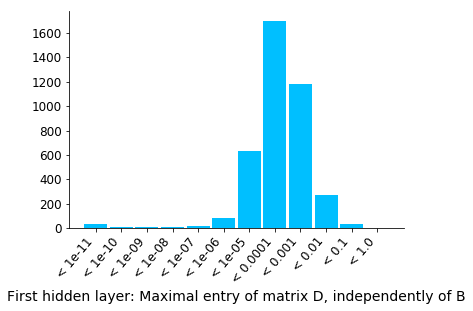

In [8]:
fig,ax = plt.subplots()
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.bar(range(len(hist)),hist,width=0.9,color='deepskyblue') 
ax.set_xticks(range(12))
ax.set_xticklabels(['< {}'.format(bins[i+1]) for i,j in enumerate(hist)],fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='right')
plt.yticks( fontsize=12)  
plt.xlabel("First hidden layer: Maximal entry of matrix D, independently of B", fontsize=14 )
# plt.title("", fontsize=22)
#plt.savefig("", bbox_inches="tight"); 
plt.show()

In [9]:
D_max_entries_for_B_positive_layer_1=[]

In [10]:
for i in range(no_of_seeds):
    for r in range(dim_layer_1):
        if B_coding_layer_1[i,r]==0:
            D_max_entries_for_B_positive_layer_1.append(D_max_entries_layer_1[i,r])

In [11]:
no_of_B_pos_def= len(D_max_entries_for_B_positive_layer_1)
print("B is positive definite in {} of {} cases.".format(no_of_B_pos_def, no_of_seeds*dim_layer_1))

B is positive definite in 547 of 4000 cases.


In [12]:
hist_pos_def,bins_pos_def= np.histogram(D_max_entries_for_B_positive_layer_1, bins=[0,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1])

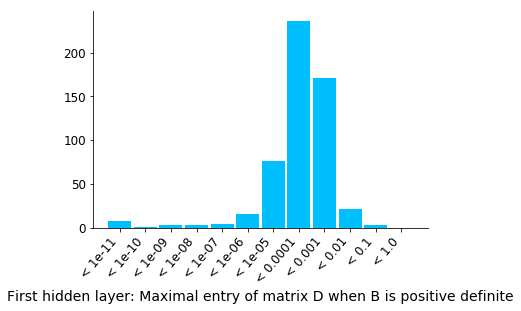

In [13]:
fig,ax = plt.subplots()
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.bar(range(len(hist_pos_def)),hist_pos_def,width=0.9,color='deepskyblue') 
ax.set_xticks(range(12))
ax.set_xticklabels(['< {}'.format(bins[i+1]) for i,j in enumerate(hist)],fontsize=12,)
plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='right')
plt.yticks( fontsize=12)  
plt.xlabel("First hidden layer: Maximal entry of matrix D when B is positive definite", fontsize=14 )
# plt.title("", fontsize=22)
#plt.savefig("", bbox_inches="tight"); 
plt.show()

# Results for the second hidden layer

In [14]:
hist,bins= np.histogram(D_max_entries_layer_2.flatten(), bins=[0,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1])

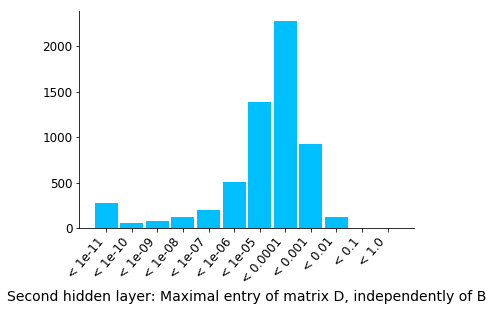

In [15]:
fig,ax = plt.subplots()
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.bar(range(len(hist)),hist,width=0.9,color='deepskyblue') 
ax.set_xticks(range(12))
ax.set_xticklabels(['< {}'.format(bins[i+1]) for i,j in enumerate(hist)],fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='right')
plt.yticks( fontsize=12)  
plt.xlabel("Second hidden layer: Maximal entry of matrix D, independently of B", fontsize=14 )
# plt.title("", fontsize=22)
#plt.savefig("", bbox_inches="tight"); 
plt.show()

In [16]:
D_max_entries_for_B_positive_layer_2=[]

In [17]:
for i in range(no_of_seeds):
    for r in range(dim_layer_1):
        if B_coding_layer_2[i,r]==0:
            D_max_entries_for_B_positive_layer_2.append(D_max_entries_layer_2[i,r])

In [18]:
no_of_B_pos_def= len(D_max_entries_for_B_positive_layer_2)
print("B is positive definite in {} of {} cases.".format(no_of_B_pos_def, no_of_seeds*dim_layer_2))

B is positive definite in 33 of 6000 cases.


In [19]:
hist_pos_def,bins_pos_def= np.histogram(D_max_entries_for_B_positive_layer_2, bins=[0,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1])

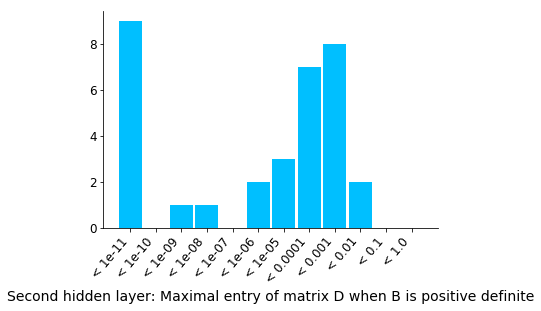

In [20]:
fig,ax = plt.subplots()
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.bar(range(len(hist_pos_def)),hist_pos_def,width=0.9,color='deepskyblue') 
ax.set_xticks(range(12))
ax.set_xticklabels(['< {}'.format(bins[i+1]) for i,j in enumerate(hist)],fontsize=12,)
plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='right')
plt.yticks( fontsize=12)  
plt.xlabel("Second hidden layer: Maximal entry of matrix D when B is positive definite", fontsize=14 )
# plt.title("", fontsize=22)
#plt.savefig("", bbox_inches="tight"); 
plt.show()

# Results for the last hidden layer

We know from theory that the matrix D is zero at every critical point, so the results for D can be consdiered as a check for the magnitude of numerical errors in the computation of the matrices D for other layers

In [21]:
hist,bins= np.histogram(D_max_entries_layer_3.flatten(), bins=[0,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1])

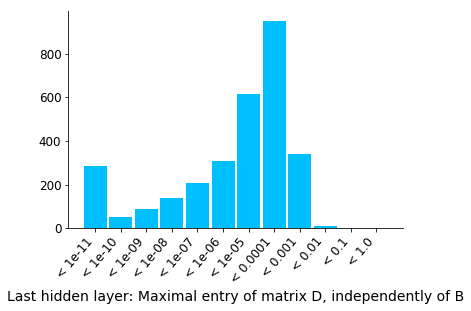

In [22]:
fig,ax = plt.subplots()
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.bar(range(len(hist)),hist,width=0.9,color='deepskyblue') 
ax.set_xticks(range(12))
ax.set_xticklabels(['< {}'.format(bins[i+1]) for i,j in enumerate(hist)],fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='right')
plt.yticks( fontsize=12)  
plt.xlabel("Last hidden layer: Maximal entry of matrix D, independently of B", fontsize=14 )
# plt.title("", fontsize=22)
#plt.savefig("", bbox_inches="tight"); 
plt.show()

In [23]:
D_max_entries_for_B_positive_layer_3=[]

In [24]:
for i in range(no_of_seeds):
    for r in range(dim_layer_3):
        if B_coding_layer_3[i,r]==0:
            D_max_entries_for_B_positive_layer_3.append(D_max_entries_layer_3[i,r])

In [25]:
no_of_B_pos_def= len(D_max_entries_for_B_positive_layer_3)
print("B is positive definite in {} of {} cases.".format(no_of_B_pos_def, no_of_seeds*dim_layer_3))

B is positive definite in 6 of 4000 cases.


In [26]:
hist_pos_def,bins_pos_def= np.histogram(D_max_entries_for_B_positive_layer_3, bins=[0,1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1])

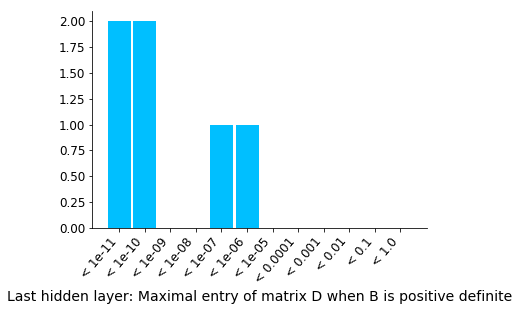

In [27]:
fig,ax = plt.subplots()
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.bar(range(len(hist_pos_def)),hist_pos_def,width=0.9,color='deepskyblue') 
ax.set_xticks(range(12))
ax.set_xticklabels(['< {}'.format(bins[i+1]) for i,j in enumerate(hist)],fontsize=12,)
plt.setp(ax.get_xticklabels(), rotation=50, horizontalalignment='right')
plt.yticks( fontsize=12)  
plt.xlabel("Last hidden layer: Maximal entry of matrix D when B is positive definite", fontsize=14 )
# plt.title("", fontsize=22)
#plt.savefig("", bbox_inches="tight"); 
plt.show()